In [1]:
import glob
import tifffile
import numpy as np
import lightgbm as lgb
import warnings
import tqdm
import pandas as pd
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
pd.options.display.max_columns = 99

In [2]:
train_path =  '../train/s2_image/'
mask_path = '../train/mask/'

masks = glob.glob(f'{mask_path}/*')
trains = glob.glob(f'{train_path}/*')
masks.sort()
trains.sort()

In [3]:
total_df = pd.DataFrame({'img_path': trains, 'mask_path':masks})

In [4]:
X_train, X_valid = train_test_split(total_df, test_size=0.2, random_state=42)

In [5]:
X = []
y = []
g = []

for i, (t, m) in enumerate(zip(X_train['img_path'], X_train['mask_path'])):
    img = tifffile.imread(t).astype(np.float64)
    mask = tifffile.imread(m).astype(np.float64)
    X.append(img.reshape(-1,12))
    y.append(mask.reshape(-1))
    g.append(np.ones_like(mask.reshape(-1))*i)

x_train = np.vstack(X)
y_train = np.hstack(y)
g_train = np.hstack(g) 

In [6]:
X = []
y = []
g = []

for i, (t, m) in enumerate(zip(X_valid['img_path'], X_valid['mask_path'])):
    img = tifffile.imread(t).astype(np.float64)
    mask = tifffile.imread(m).astype(np.float64)
    X.append(img.reshape(-1,12))
    y.append(mask.reshape(-1))
    g.append(np.ones_like(mask.reshape(-1))*i)

x_valid = np.vstack(X)
y_valid = np.hstack(y)
g_valid = np.hstack(g) 

In [7]:
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(906143, 12) (906143,) (227429, 12) (227429,)


In [8]:
x_train = pd.DataFrame(x_train, columns=['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'])
x_train['NDRE_1'] = (x_train['B11']-x_train['B12'])/(x_train['B11']+x_train['B12'])
g_train = pd.DataFrame(g_train, columns=['Group'])

x_train = pd.concat([x_train, g_train], 1)
x_valid = pd.DataFrame(x_valid, columns=['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'])
x_valid['NDRE_1'] = (x_valid['B11']-x_valid['B12'])/(x_valid['B11']+x_valid['B12'])
g_valid = pd.DataFrame(g_valid, columns=['Group'])
x_valid = pd.concat([x_valid, g_valid], 1)

x_train['Albedo'] = (x_train['B11'])/(x_train['B4'])
x_valid['Albedo'] = (x_valid['B11'])/(x_valid['B4'])

x_train['LAI'] = (x_train['B8']- x_train['B4'])/(x_train['B8'])
x_valid['LAI'] = (x_valid['B8']- x_valid['B4'])/(x_valid['B8'])

x_train['UI'] = (x_train['B11']- x_train['B12'])/(x_train['B11'] + x_train['B12'])
x_valid['UI'] = (x_valid['B11']- x_valid['B12'])/(x_valid['B11'] + x_valid['B12'])

x_train['AI'] = (x_train['B8']- x_train['B11'])/(x_train['B8'] + x_train['B11'])
x_valid['AI'] = (x_valid['B8']- x_valid['B11'])/(x_valid['B8'] + x_valid['B11'])


In [9]:
x_train = x_train.drop(columns=['Group'], axis=1)
x_valid = x_valid.drop(columns=['Group'], axis=1)

In [10]:
from catboost import CatBoostClassifier, Pool, cv

In [11]:
model_cat = CatBoostClassifier(iterations=2000,
                           task_type="GPU",
                           verbose=100,
                           learning_rate=0.05,
                           depth=10 ,#min 4,
                        #    eval_metric = 'F1',
                           devices='0:1')

In [12]:
model_cat.fit(x_train,
            y_train,eval_set=(x_valid, y_valid),
            verbose=100)

0:	learn: 0.5872935	test: 0.5882896	best: 0.5882896 (0)	total: 19.3ms	remaining: 38.5s
100:	learn: 0.0886120	test: 0.1033333	best: 0.1033333 (100)	total: 2.01s	remaining: 37.8s
200:	learn: 0.0813816	test: 0.0996669	best: 0.0996667 (199)	total: 4.01s	remaining: 35.9s
300:	learn: 0.0764497	test: 0.0978966	best: 0.0978966 (300)	total: 6.01s	remaining: 33.9s
400:	learn: 0.0724554	test: 0.0972042	best: 0.0971777 (399)	total: 8.01s	remaining: 31.9s
500:	learn: 0.0692148	test: 0.0964505	best: 0.0964487 (498)	total: 10s	remaining: 29.9s
600:	learn: 0.0663775	test: 0.0960510	best: 0.0960197 (591)	total: 12s	remaining: 27.9s
700:	learn: 0.0637309	test: 0.0956994	best: 0.0956994 (700)	total: 14s	remaining: 25.9s
800:	learn: 0.0615234	test: 0.0955372	best: 0.0955155 (774)	total: 16s	remaining: 23.9s
900:	learn: 0.0593968	test: 0.0953799	best: 0.0953732 (890)	total: 18s	remaining: 21.9s
1000:	learn: 0.0575197	test: 0.0952891	best: 0.0952891 (1000)	total: 20s	remaining: 19.9s
1100:	learn: 0.0556750	

In [13]:
0.0952

0.0952

In [14]:
pred = model_cat.predict_proba(x_valid) 
pred_mask = (pred[:,1] > 0.4).astype(np.uint8) #(1000)

In [15]:
f1_score(y_valid, pred_mask) #average='weighted'

0.800175862826995

In [16]:
test_path =  '../evaluation/'
test_mask_path = '../sample/'

masks = glob.glob(f'{test_mask_path}/*')
tests = glob.glob(f'{test_path}/*')
masks.sort()
tests.sort()

In [17]:
import os
if not os.path.isdir('plz'):
    os.mkdir('plz')

In [18]:
threshold=0.4

pred_mask_list=[]
proba_list=[]
for i, (m, t) in tqdm.tqdm(enumerate(zip(masks, tests))):
    basename = os.path.basename(m)
    output_file = f'plz/{basename}'
    
    img = tifffile.imread(t).astype(np.float64)
    mask = tifffile.imread(m).astype(np.float64)

    X = img.reshape(-1, 12)
    #######################
    df_x = pd.DataFrame(X, columns=['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'])
    df_x['NDRE_1'] = (df_x['B11']-df_x['B12'])/(df_x['B11']+df_x['B12'])

    df_x['Albedo'] = (df_x['B11'])/(df_x['B4'])
    df_x['LAI'] = (df_x['B8']- df_x['B4'])/(df_x['B8'])

    df_x['UI'] = (df_x['B11']- df_x['B12'])/(df_x['B11'] + df_x['B12'])
    df_x['AI'] = (df_x['B8']- df_x['B11'])/(df_x['B8'] + df_x['B11'])

    X = np.array(df_x)
    #######################
    shape_mask = mask.shape
    
    pred = model_cat.predict_proba(X) 

    pred_mask = (pred[:,1] > threshold).astype(np.uint8).reshape(shape_mask[0], shape_mask[1]) #(23,23)
    proba_list.append(pred_mask)

    pred_mask_list.append(pred_mask)
    tifffile.imwrite(output_file, pred_mask)

2066it [00:16, 122.92it/s]


In [19]:
import zipfile

output_folder_path = 'plz'
with zipfile.ZipFile('output_1105.zip', 'w') as zipf:
    for root, dirs, files in os.walk(output_folder_path):
        for file in files:
            zipf.write(os.path.join(root, file), file)

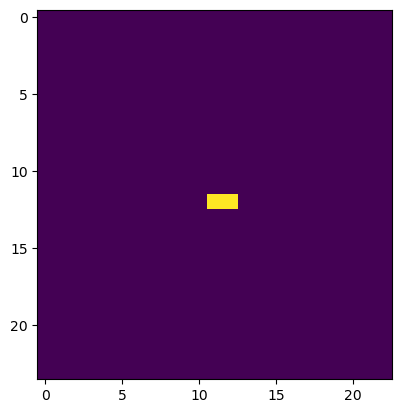

In [20]:
import matplotlib.pyplot as plt
plt.imshow(pred_mask_list[2])